# Imports

In [1]:
#Imports
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
import lightgbm as lgb
from scipy.stats import spearmanr

sns.set_style("white")
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline
set_matplotlib_formats('svg')

plt.rcParams["font.family"] = "Times New Roman" # !!!!
plt.rcParams.update({'font.size': 32})


/tmp/ipykernel_115328/3791004227.py:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


# Loading Files

In [9]:
df_config = pd.read_csv("../data/train_mixture_1m_wiki40b.csv")
df_config = df_config.reindex(sorted(df_config.columns), axis=1)
df_config.head()

,index,train_wiki40b_de,train_wiki40b_en,train_wiki40b_es,train_wiki40b_fr,train_wiki40b_it,train_wiki40b_ru
0,1,0.3610,0.0756,0.2088,0.2630,0.0176,0.0744
1,2,0.0022,0.7176,0.0000,0.2078,0.0718,0.0004
2,3,0.0076,0.4366,0.0950,0.2148,0.0636,0.1824
3,4,0.0000,0.4402,0.0000,0.0000,0.2808,0.2790
4,5,0.0000,0.0034,0.0000,0.9946,0.0000,0.0020


In [10]:
df_wandb = pd.read_csv("../data/train_loss_1m_wiki40b.csv")
df_wandb = df_wandb.reindex(sorted(df_wandb.columns), axis=1)
df_wandb.head()


,index,metric/wiki40b_ca_val_loss,metric/wiki40b_da_val_loss,metric/wiki40b_nl_val_loss,metric/wiki40b_pl_val_loss,metric/wiki40b_pt_val_loss,metric/wiki40b_ro_val_loss,metric/wiki40b_tr_val_loss,metric/wiki40b_uk_val_loss
0,1,7.590892,9.712281,9.225526,10.219563,8.088976,8.325221,10.457393,9.111112
1,2,8.332706,9.724741,9.262928,10.052660,8.801690,11.839948,10.213622,9.267040
2,3,7.622749,9.690910,9.166158,10.096927,7.995955,12.008623,10.271949,9.082519
3,4,8.486435,9.796930,9.387952,10.085783,8.845107,11.922897,10.244525,8.990097
4,5,8.593649,9.866178,9.364097,10.142113,9.066130,9.556341,10.463908,9.104890


In [11]:
X_train = df_config[df_config.columns[1:]].values
X_train.shape

(512, 6)

In [12]:
y_train = df_wandb[df_wandb.columns[1:]].values
y_train.shape

(512, 8)

In [13]:
df_config = pd.read_csv("../data/test_mixture_1m_wiki40b.csv")
df_config = df_config.reindex(sorted(df_config.columns), axis=1)
# df_config = df_config.head(105)
df_config

,index,train_wiki40b_de,train_wiki40b_en,train_wiki40b_es,train_wiki40b_fr,train_wiki40b_it,train_wiki40b_ru
0,513,0.0000,0.0000,0.0000,0.0000,0.9952,0.0048
1,514,0.0308,0.0000,0.9688,0.0004,0.0000,0.0000
2,515,0.0344,0.0000,0.0000,0.0068,0.9586,0.0000
3,516,0.0000,0.1820,0.7866,0.0000,0.0000,0.0314
4,517,0.0000,0.0746,0.0016,0.4956,0.4204,0.0078
...,...,...,...,...,...,...,...
251,764,0.3296,0.3120,0.1012,0.2460,0.0112,0.0002
252,765,0.0026,0.4796,0.0238,0.1530,0.3180,0.0228
253,766,0.5840,0.0888,0.2046,0.1204,0.0000,0.0022
254,767,0.8306,0.0192,0.0142,0.0560,0.0800,0.0000


In [14]:
df_wandb = pd.read_csv("../data/test_loss_1m_wiki40b.csv")
df_wandb = df_wandb.reindex(sorted(df_wandb.columns), axis=1)
df_wandb

,index,metric/wiki40b_ca_val_loss,metric/wiki40b_da_val_loss,metric/wiki40b_nl_val_loss,metric/wiki40b_pl_val_loss,metric/wiki40b_pt_val_loss,metric/wiki40b_ro_val_loss,metric/wiki40b_tr_val_loss,metric/wiki40b_uk_val_loss
0,513,8.577722,9.887462,9.540814,10.482224,9.000724,9.876997,10.535697,9.140335
1,514,7.528107,9.549414,9.246161,10.299830,7.897141,8.942793,10.402512,11.336105
2,515,8.205967,9.647319,9.259621,10.382769,8.852687,9.684121,10.439553,10.847031
3,516,7.632667,9.788818,9.481116,10.243583,7.925220,9.003502,10.357868,9.155539
4,517,7.938254,9.791453,9.315654,10.191554,8.300632,8.952356,10.276037,9.111151
...,...,...,...,...,...,...,...,...,...
251,764,7.654891,9.780745,9.314403,10.201249,8.046494,11.341743,10.468107,9.470997
252,765,7.659403,9.665525,9.219646,10.149481,8.042487,11.856374,10.353325,9.137178
253,766,7.699350,9.832061,9.319826,10.210443,8.156794,11.601899,10.507512,9.117549
254,767,7.728045,9.690895,9.196586,10.204675,8.132087,8.618824,10.431734,10.662351


In [15]:
X_test = df_config[df_config.columns[1:]].values
X_test.shape


(256, 6)

In [16]:
y_test = df_wandb[df_wandb.columns[1:]].values
y_test.shape

(256, 8)

In [17]:
KEY_METRICS = df_wandb.columns[1:].tolist()
KEY_METRICS

['metric/wiki40b_ca_val_loss',
 'metric/wiki40b_da_val_loss',
 'metric/wiki40b_nl_val_loss',
 'metric/wiki40b_pl_val_loss',
 'metric/wiki40b_pt_val_loss',
 'metric/wiki40b_ro_val_loss',
 'metric/wiki40b_tr_val_loss',
 'metric/wiki40b_uk_val_loss']

# Fitting

In [18]:
import numpy as np
import lightgbm as lgb
from scipy.stats import spearmanr

hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1', 'l2'],
    "num_iterations": 1000,
    'seed': 42,
    'learning_rate': 1e-2,
    "verbosity": -1,
}

np.random.seed(42)


# dictionary with language name : loss path
all_language_metrics = {
    'ca': 'metric/wiki40b_ca_val_loss',
    'da': 'metric/wiki40b_da_val_loss',
    'nl': 'metric/wiki40b_nl_val_loss',
    'pl': 'metric/wiki40b_pl_val_loss',
    'pt': 'metric/wiki40b_pt_val_loss',
    'ro': 'metric/wiki40b_ro_val_loss',
    'tr': 'metric/wiki40b_tr_val_loss',
    'uk': 'metric/wiki40b_uk_val_loss'
}


# Create ablation configurations
ablation_configs = {
    'T1': {
            'name': 'uk+ca+da+ro',
            'metrics': ['uk', 'ca', 'da', 'ro']
        },
        'T2': {
            'name': 'pl+uk+nl+pt+ca+tr+da+ro',
            'metrics': ['pl', 'uk', 'nl', 'pt', 'ca', 'tr', 'da', 'ro']
        },

}

# Create a map from metrics to their indices
metric_to_idx = {metric: KEY_METRICS.index(metric_name) for metric, metric_name in all_language_metrics.items()}


In [19]:

# Function to compute average of selected reasoning tasks
def compute_reasoning_avg(X, task_list):
    indices = [metric_to_idx[task] for task in task_list]
    return np.mean([X[:, idx] for idx in indices], axis=0)

# Dictionary to store all trained models
all_predictors = {}

# Train ablation models
print("\nTraining ablation models...")
ablation_predictors = {}

for ablation_id, config in ablation_configs.items():
    print(f"\nTraining {ablation_id}: {config['name']}...")
    
    # Get the metrics for this ablation
    ablation_metrics = config['metrics']
    
    # Compute average targets for training and testing
    ablation_avg_train = compute_reasoning_avg(y_train, ablation_metrics)
    ablation_avg_test = compute_reasoning_avg(y_test, ablation_metrics)
    
    # Train the model
    gbm = lgb.LGBMRegressor(**hyper_params)
    
    reg = gbm.fit(X_train, ablation_avg_train,
        eval_set=[(X_test, ablation_avg_test)],
        eval_metric='l2', callbacks=[
        lgb.early_stopping(stopping_rounds=3, verbose=False),
    ])
    
    r, p = spearmanr(reg.predict(X_test), ablation_avg_test)
    print(f"{ablation_id} ({config['name']}) Correlation: {np.round(r*100, 2)}%")
    
    ablation_predictors[ablation_id] = reg
    all_predictors[ablation_id] = reg

def predict_all_metrics(X_new):
    results = {
        "commoncrawl_loss": all_predictors['commoncrawl'].predict(X_new)
    }
    
    for ablation_id, config in ablation_configs.items():
        results[f"{ablation_id}_{config['name']}"] = all_predictors[ablation_id].predict(X_new)
    
    return results

print("\nAll models trained and ready for predictions.")


Training ablation models...

Training T1: uk+ca+da+ro...
T1 (uk+ca+da+ro) Correlation: 95.51%

Training T2: pl+uk+nl+pt+ca+tr+da+ro...
T2 (pl+uk+nl+pt+ca+tr+da+ro) Correlation: 94.67%

All models trained and ready for predictions.


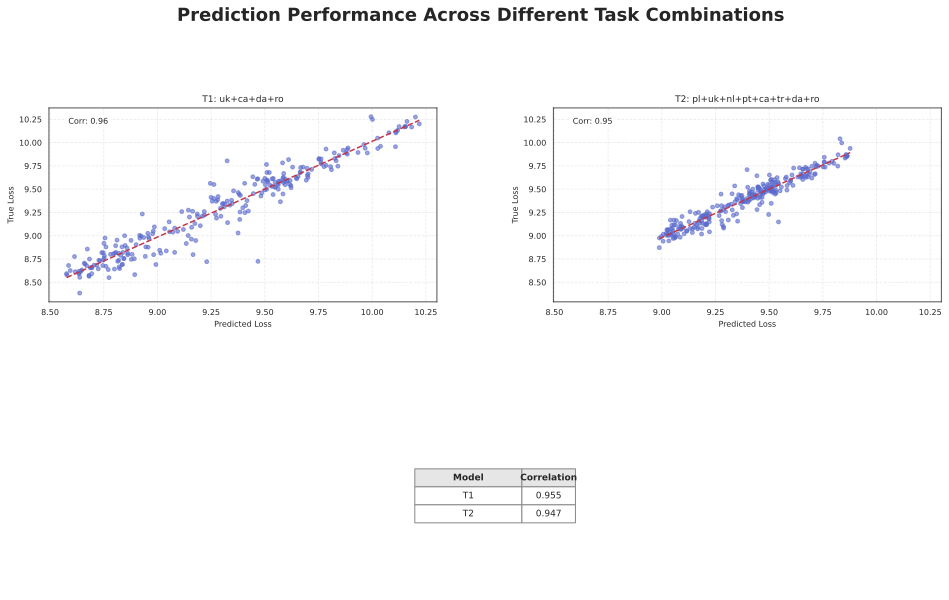

Visualization complete.


In [20]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
from scipy.stats import spearmanr
import matplotlib.colors as mcolors
from matplotlib.cm import get_cmap

# Set basic parameters
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.titlesize'] = 10

# Function to create visualization for a specific target
def create_subplot(ax, predictor, X_test, y_true, title, y_min=None, y_max=None, x_min=None, x_max=None):
    y_pred = predictor.predict(X_test)
    
    ax.scatter(y_pred, y_true, s=15, color='#5969CB', alpha=0.6)
    
    m, b = np.polyfit(y_pred, y_true, 1)
    x_range = np.linspace(min(y_pred), max(y_pred), 100)
    ax.plot(x_range, m * x_range + b, color='#C3364A', linewidth=1.5, linestyle='dashed')
    
    r, p = spearmanr(y_pred, y_true)
    ax.text(0.05, 0.95, f'Corr: {r:.2f}', transform=ax.transAxes,
            fontsize=8, va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    ax.set_xlabel('Predicted Loss', fontsize=8)
    ax.set_ylabel('True Loss', fontsize=8)
    
    if len(title) > 30:
        parts = title.split(':')
        if len(parts) > 1:
            short_title = parts[0] + ':\n' + parts[1]
        else:
            short_title = title[:15] + '\n' + title[15:]
        ax.set_title(short_title, fontsize=9)
    else:
        ax.set_title(title, fontsize=9)
    
    if y_min is not None and y_max is not None:
        ax.set_ylim(y_min, y_max)
    if x_min is not None and x_max is not None:
        ax.set_xlim(x_min, x_max)
    
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.tick_params(axis='both', which='major', labelsize=8)
    
    return r, min(y_pred), max(y_pred), min(y_true), max(y_true)

# Create figure
plt.figure(figsize=(16, 14))

grid = GridSpec(3, 2, figure=plt.gcf(), 
                height_ratios=[1, 1,1],
                hspace=0.5,
                wspace=0.3)

# Track correlations and axis limits
correlations = {}
y_min_global, y_max_global = float('inf'), float('-inf')
x_min_global, x_max_global = float('inf'), float('-inf')


positions = [
    (0, 0), (0, 1),
    (1, 0)
]

for (ablation_id, config), pos in zip(ablation_configs.items(), positions):
    ablation_avg_test = compute_reasoning_avg(y_test, config['metrics'])
    predictor = all_predictors[ablation_id]
    y_pred = predictor.predict(X_test)
    
    y_min_global = min(y_min_global, min(ablation_avg_test))
    y_max_global = max(y_max_global, max(ablation_avg_test))
    x_min_global = min(x_min_global, min(y_pred))
    x_max_global = max(x_max_global, max(y_pred))

# Add padding to limits
y_padding = (y_max_global - y_min_global) * 0.05
x_padding = (x_max_global - x_min_global) * 0.05
y_min_global -= y_padding
y_max_global += y_padding
x_min_global -= x_padding
x_max_global += x_padding



positions = [
    (0, 0), (0, 1),
    (1, 0)
]

# Create plots for ablation models
for (ablation_id, config), pos in zip(ablation_configs.items(), positions):
    ablation_avg_test = compute_reasoning_avg(y_test, config['metrics'])
    ax = plt.subplot(grid[pos[0], pos[1]])
    
    if len(config['name']) > 50:
        title = f"{ablation_id}"
    else:
        title = f"{ablation_id}: {config['name']}"
    
    r, _, _, _, _ = create_subplot(
        ax=ax,
        predictor=all_predictors[ablation_id],
        X_test=X_test,
        y_true=ablation_avg_test,
        title=title,
        y_min=y_min_global, y_max=y_max_global,
        x_min=x_min_global, x_max=x_max_global
    )
    correlations[ablation_id] = r

# Create table
ax = plt.subplot(grid[1, :])
ax.axis('off')

sorted_correlations = sorted(correlations.items(), key=lambda x: x[1], reverse=True)
table_data = [["Model", "Correlation"]]
for model, corr in sorted_correlations:
    table_data.append([model, f"{corr:.3f}"])

table = ax.table(
    cellText=table_data[1:],
    colLabels=table_data[0],
    loc='center',
    cellLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.5)

for (row, col), cell in table.get_celld().items():
    if col == 0:
        cell.set_width(0.12)
    elif col == 1:
        cell.set_width(0.06)
        
    if row == 0:
        cell.set_text_props(weight='bold')
        cell.set_facecolor('#E6E6E6')
    cell.set_edgecolor('#888888')


plt.suptitle("Prediction Performance Across Different Task Combinations", 
            fontsize=18, y=0.98, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('prediction_performance.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("Visualization complete.")

# Simulate

Sample shape: (100000, 6)

Running simulations for each ablation configuration...

Simulating for T1...
Top-128 samples shape: (128, 6)

Optimal data mixture for T1 - uk+ca+da+ro:
          Domain  uk+ca+da+ro Weight
train_wiki40b_en            0.158118
train_wiki40b_fr            0.047490
train_wiki40b_de            0.281005
train_wiki40b_es            0.222649
train_wiki40b_it            0.068326
train_wiki40b_ru            0.222411
train_dw: "0.16,0.05,0.28,0.22,0.07,0.22"


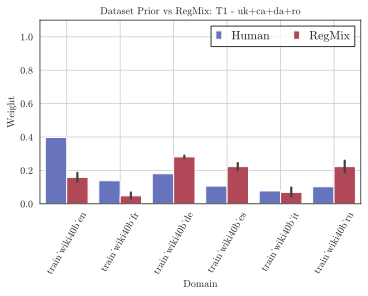


Simulating for T2...
Top-128 samples shape: (128, 6)

Optimal data mixture for T2 - pl+uk+nl+pt+ca+tr+da+ro:
          Domain  pl+uk+nl+pt+ca+tr+da+ro Weight
train_wiki40b_en                        0.027799
train_wiki40b_fr                        0.085805
train_wiki40b_de                        0.166135
train_wiki40b_es                        0.286278
train_wiki40b_it                        0.069626
train_wiki40b_ru                        0.364356
train_dw: "0.03,0.09,0.17,0.29,0.07,0.36"


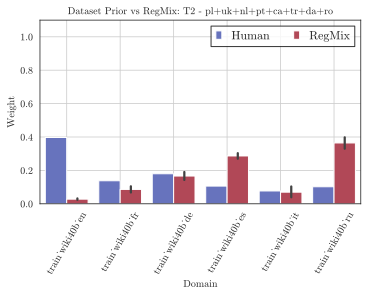

In [23]:
# Simulation for different metrics with dataset distribution
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import yaml

# Set random seed for reproducibility
np.random.seed(42)

# dataset domain names and distribution
dataset_domains = [
    "train_wiki40b_en",
    "train_wiki40b_fr",
    "train_wiki40b_de",
    "train_wiki40b_es",
    "train_wiki40b_it",
    "train_wiki40b_ru"
]

# Domain short names for JSON format
domain_short_names = [
    "en",
    "fr",
    "de",
    "es",
    "it",
    "ru"
]


# "train_wiki40b_en": 0.40,  # English: 1988.8M / 5011.2M ≈ 39.7%
# "train_wiki40b_fr": 0.14,  # French: 689.3M / 5011.2M ≈ 13.8%
# "train_wiki40b_de": 0.18,  # German: 901.6M / 5011.2M ≈ 18.0%
# "train_wiki40b_es": 0.11,  # Spanish: 532.3M / 5011.2M ≈ 10.6%
# "train_wiki40b_it": 0.08,  # Italian: 385.4M / 5011.2M ≈ 7.7%
# "train_wiki40b_ru": 0.10,  # Russian: 513.8M / 5011.2M ≈ 10.3%

#  original distribution weights

wiki40b_prior_dist = [
    0.397,  # English
    0.138,  # French
    0.180,  # German
    0.106,  # Spanish
    0.077,  # Italian
    0.102   # Russian
]

# Generate samples from Dirichlet distribution based on dataset distribution
samples = np.random.dirichlet(np.array(wiki40b_prior_dist) * 1, 100000)
print(f"Sample shape: {samples.shape}")

# Function to simulate and visualize for a specific metric
def simulate_and_visualize(predictor, ablation_id, k=128):
    if ablation_id == 'commoncrawl':
       config = ablation_configs['T8']
       metric_name = 'Commoncrawl'
    else:
        config = ablation_configs[ablation_id]
        metric_name = config['name']
    
    # Predict using the given model
    simulation = predictor.predict(samples)
    
    # Histogram of predictions
    plt.figure(figsize=(10, 6))
    plt.hist(simulation, bins=32)
    plt.xlabel('Pred Loss')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Predicted {metric_name} Loss')
    plt.savefig(f'../misc_wiki40b/dataset_hist_{ablation_id.lower()}.png')
    plt.close()
    
    # Find optimal data mixture (top-k samples with lowest predicted loss)
    top_k_indices = np.argsort(simulation)[:k]
    top_k_samples = samples[top_k_indices]
    print(f"Top-{k} samples shape: {top_k_samples.shape}")
    
    optimal_data_mixture = np.mean(top_k_samples, axis=0)
    
    optimal_mix_df = pd.DataFrame({
        'Domain': [domain.split('train_dataset_')[-1] for domain in dataset_domains],
        f'{metric_name} Weight': optimal_data_mixture
    })

    print(f"\nOptimal data mixture for {ablation_id} - {metric_name}:")
    print(optimal_mix_df.to_string(index=False))
    
    # Generate JSON-ready train_dw string
    train_dw = ",".join([f"{w:.2f}" for w in optimal_data_mixture])
    print(f"train_dw: \"{train_dw}\"")
    
    df = pd.DataFrame(
        data=np.concatenate([np.array([wiki40b_prior_dist]), top_k_samples], axis=0), 
        columns=[domain.split('train_dataset_')[-1] for domain in dataset_domains]
    )
    df = pd.melt(df)
    df['type'] = (['Human'] + ['RegMix'] * top_k_samples.shape[0]) * len(dataset_domains)
    
    plt.rc('axes', unicode_minus=False)
    plt.rcParams.update({
        'text.usetex': False,
        'font.family': 'serif',
        'font.serif': 'cmr10',
        'mathtext.fontset': 'cm',
    })
    
    fig, ax = plt.subplots(figsize=(5,4), layout='compressed')
    
    pal = {
        'Human': '#5969CB',
        'RegMix': '#C3364A',
    }
    
    sns.barplot(
        data=df,
        x='variable',
        y='value',
        hue='type',
        palette=pal
    )
    
    ax.tick_params(axis='x', labelrotation=60, labelsize=10)
    ax.legend(
        edgecolor='black',
        fancybox=False,
        prop={'size': 12},
        handlelength=0.5,
        ncol=2,
    )
    
    ax.grid(True)
    ax.set_ylim(0, 1.1, )
    ax.set_xlabel('Domain', fontdict={'size': 10}) 
    ax.set_ylabel('Weight', fontdict={'size': 10})  
    ax.tick_params(axis='y', labelsize=10)
    ax.set_title(f'Dataset Prior vs RegMix: {ablation_id} - {metric_name}', fontdict={'size': 10})  
    plt.show()
    plt.close()
    
    optimal_mixture_dict = {}
    for domain, weight in zip(dataset_domains, optimal_data_mixture):
        optimal_mixture_dict[domain] = float(weight)
    
    optimal_df = pd.DataFrame({
        'Domain': dataset_domains,
        'Weight': optimal_data_mixture
    })

    json_config = {
        "dataset": f"slim_ood-{'-'.join(config['metrics'])}",
        "train_domains": ",".join(domain_short_names),
        "tgt_domains": ','.join(config['metrics']),
        "max_steps": 20000,
        "train_dw": train_dw,
        "tgt_dw": None,
        "val_dw": None,
        "max_train_samples": None,
        "max_eval_samples": 5000,
        "max_token_length": 512,
        "seed": 16,
        "preprocessing_num_workers": 2,
        "model_name_or_path": None,
        "model_type": "gpt2",
        "config_overrides": "n_positions=512,n_embd=768,n_layer=12,n_head=12",
        "run_name": f"REGMIX-125M",
        "output_dir": "/mloscratch/homes/glarou/DoGE/regmix/multi_doge/exp",
        "do_train": True,
        "do_eval": True,
        "do_predict": False,
        "learning_rate": 0.0005,
        "weight_decay": 0.01,
        "reweight_train": "None",
        "reweight_tgt": "None",
        "reweight_train_iters": 0,
        "reweight_tgt_iters": 0,
        "ref_model": None,
        "lr_scheduler_name": "linear_warmup_cosine",
        "lr_end": 0.0001,
        "reweight_eps": 0.0,
        "mu_train": 0.001,
        "mu_tgt": 0.0002,
        "max_grad_norm": 5.0,
        "per_device_train_batch_size": 16,
        "warmup_ratio": 0.05,
        "warmup_steps": 500,
        "save_steps": 5000,
        "eval_steps": 500,
        "gradient_accumulation_steps": 2,
        "save_strategy": "steps",
        "evaluation_strategy": "steps",
        "logging_steps": 50,
        "save_total_limit": 10,
        "ddp_find_unused_parameters": False,
        "use_cpu": False,
        "compute_pertoken_losses": False,
        "overwrite_output_dir": False
    }
    # if misc_wiki40b is not in the path, create the directory
    import os
    if not os.path.exists('../misc_wiki40b/configs_wiki40b'):
        os.makedirs('../misc_wiki40b/configs_wiki40b')
    with open(f'../misc_wiki40b/configs_wiki40b/{ablation_id}-regmix.json', 'w') as f:
        import json
        json.dump(json_config, f, indent=2)
    
    return optimal_data_mixture, optimal_mixture_dict, json_config

print("\nRunning simulations for each ablation configuration...")
optimal_mixtures = {}
optimal_mixture_dicts = {}
json_configs = {}

for ablation_id, predictor in all_predictors.items():
    if ablation_id in ablation_configs:
        print(f"\nSimulating for {ablation_id}...")
        optimal_mixtures[ablation_id], optimal_mixture_dicts[ablation_id], json_configs[ablation_id] = simulate_and_visualize(predictor, ablation_id)



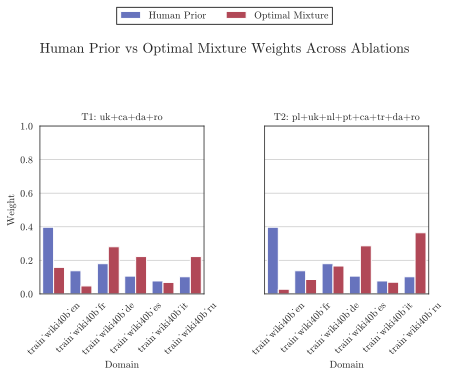

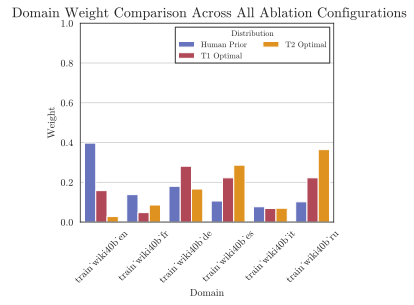

Wiki40b simulation with ablation configurations complete. Config files and plots saved as PNG.


In [28]:
def plot_all_ablations_comparison():
    """
    Create a single plot with subplots for each ablation configuration compared to "human" weights.
    """
    t_ablations = {k: v for k, v in ablation_configs.items() if k.startswith('T')}
    n_ablations = len(t_ablations) + 1
    
    n_cols = 2
    n_rows = (n_ablations + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(7, 4*n_rows), sharey=True)
    axes = axes.flatten()
    
    # Set up domain labels for x-axis (shorter names for better display)
    domain_labels = [domain.split('train_dataset_')[-1] for domain in dataset_domains]
    
    pal = {
        'Human Prior': '#5969CB',
        'Optimal Mixture': '#C3364A',
    }
    
    
    # Plot each ablation configuration
    for i, (ablation_id, config) in enumerate(t_ablations.items()):
        if i < len(axes) and ablation_id in optimal_mixtures:
            ax = axes[i]
            
            plot_df = pd.DataFrame({
                'Domain': domain_labels,
                'Human Prior': wiki40b_prior_dist,
                'Optimal Mixture': optimal_mixtures[ablation_id]
            })
            
            plot_df_melted = pd.melt(plot_df, id_vars=['Domain'], 
                                    value_vars=['Human Prior', 'Optimal Mixture'], 
                                    var_name='Distribution', value_name='Weight')
            
            sns.barplot(data=plot_df_melted, x='Domain', y='Weight', hue='Distribution', 
                        palette=pal, ax=ax)
            
            ax.set_title(f'{ablation_id}: {config["name"]}', fontsize=10)
            ax.set_ylim(0, 1)  
            ax.tick_params(axis='x', rotation=45, labelsize=10)
            ax.tick_params(axis='y', labelsize=10)
            # Only show y-label on the leftmost subplots
            if i % n_cols == 0:
                ax.set_ylabel('Weight', fontsize=10)
            else:
                ax.set_ylabel('')
            
            ax.set_xlabel('Domain', fontsize=10)
            ax.grid(True, axis='y')


    # Hide any unused subplots
    for i in range(len(t_ablations), len(axes)):
        axes[i].set_visible(False)
    
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=10, 
               fancybox=False, edgecolor='black', bbox_to_anchor=(0.5, 1.05))
    
    for ax in axes:
        if ax.get_legend() is not None:
            ax.get_legend().remove()
    
    fig.suptitle('Human Prior vs Optimal Mixture Weights Across Ablations', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    plt.savefig('../misc_wiki40b/all_ablations_comparison.png', 
                bbox_inches='tight', pad_inches=0.1, dpi=300)
    
    plt.close()

def plot_all_weights_in_single_barplot():
    """
    Create a single barplot showing all the different domain weights for each configuration.
    """
    domain_labels = [domain.split('train_dataset_')[-1] for domain in dataset_domains]
    
    t_ablations = {k: v for k, v in ablation_configs.items() if k.startswith('T')}
    
    plot_data = {'Domain': [], 'Distribution': [], 'Weight': []}
    
    for domain, weight in zip(domain_labels, wiki40b_prior_dist):
        plot_data['Domain'].append(domain)
        plot_data['Distribution'].append('Human Prior')
        plot_data['Weight'].append(weight)
    
    for ablation_id, config in t_ablations.items():
        if ablation_id in optimal_mixtures:
            for domain, weight in zip(domain_labels, optimal_mixtures[ablation_id]):
                plot_data['Domain'].append(domain)
                plot_data['Distribution'].append(f'{ablation_id} Optimal')
                plot_data['Weight'].append(weight)
    
    plot_df = pd.DataFrame(plot_data)
    
    distributions = ['Human Prior'] + [f'{aid} Optimal' for aid in t_ablations.keys() if aid in optimal_mixtures]
    colors = ['#5969CB', '#C3364A', '#FF9800', '#4CAF50', '#9C27B0', 
              '#2196F3', '#F44336', '#FFEB3B', '#795548', '#03A9F4', 
              '#673AB7', '#FFC107', '#009688', '#E91E63']
    pal = {dist: color for dist, color in zip(distributions, colors[:len(distributions)])}
    
    plt.figure(figsize=(5,5))
    
    ax = sns.barplot(data=plot_df, x='Domain', y='Weight', hue='Distribution', 
                    palette=pal)
    
    ax.set_title(' Domain Weight Comparison Across All Ablation Configurations', fontsize=14)
    ax.set_ylim(0, 1)
    ax.set_xlabel('Domain', fontsize=10)
    ax.set_ylabel('Weight', fontsize=10)
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(True, axis='y')
    
    plt.legend(title='Distribution', fontsize=8, title_fontsize=8,
               edgecolor='black', fancybox=False, ncol=2, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    plt.savefig('../misc_wiki40b/all_optimal_weights_comparison.png', 
                bbox_inches='tight', pad_inches=0.1, dpi=300)
    
    plt.close()

plot_all_ablations_comparison()
plot_all_weights_in_single_barplot()

print("Wiki40b simulation with ablation configurations complete. Config files and plots saved as PNG.")